In [1]:
# -*- coding: utf-8 -*-

#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


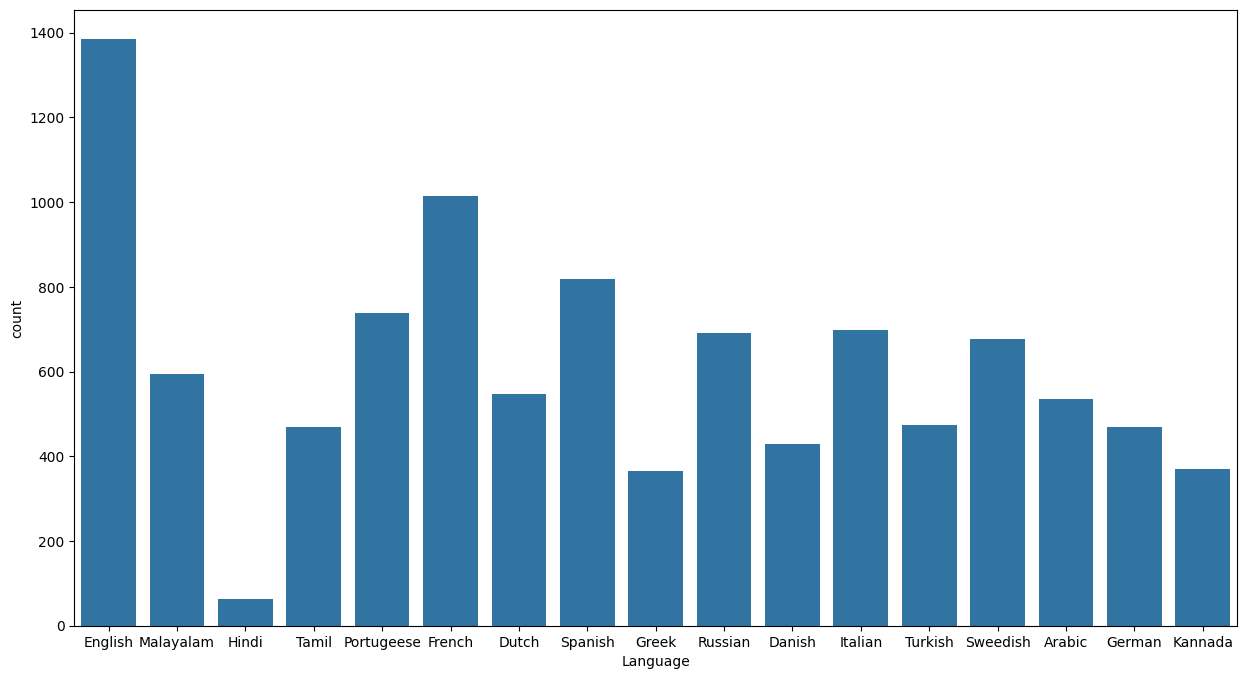

Missing rows count: 
Text        0
Language    0
dtype: int64
Duplicated rows count: 
66
Label Distributions: Counter({'English': 1385, 'French': 1014, 'Spanish': 819, 'Portugeese': 739, 'Italian': 698, 'Russian': 692, 'Sweedish': 676, 'Malayalam': 594, 'Dutch': 546, 'Arabic': 536, 'Turkish': 474, 'German': 470, 'Tamil': 469, 'Danish': 428, 'Kannada': 369, 'Greek': 365, 'Hindi': 63})


<ipython-input-3-f82ce05d8623>:47: FutureWarning: Possible nested set at position 1
  word = re.sub(r'[[]]', '', word)


In [3]:
"""
Acquire & Preprocess Data
"""


df = pd.read_csv('/content/gdrive/MyDrive/COMP 550 - Final Project/Datasets/Language Detection.csv')

# Plot data
plt.figure(figsize = (15, 8))
sns.countplot(x = df['Language'])
plt.show()


texts = df['Text']
languages = df['Language']


# Check missing values and drop if there is any
print(f'Missing rows count: \n{df.isnull().sum()}')


df.dropna(inplace=True)
df.dropna(axis=1, inplace=True)


# Check duplicated rows and drop if there is any
print(f'Duplicated rows count: \n{df.duplicated().sum()}')


df.drop_duplicates(inplace=True)


from collections import Counter
print(f"Label Distributions: {Counter(languages)}")


texts = df['Text']
languages = df['Language']


word_list = []


# Remove special characters and numbers
for word in texts:
 word = re.sub(r'[!@#$(),"%^*?:;~`0-9]', '', word)
 word = re.sub(r'[[]]', '', word)
 word = word.lower()
 word_list.append(word)


# N-gram vectorization
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X_ngrams = vectorizer.fit_transform(word_list)


# Tf-idf vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
X_tfidf = tfidf_vectorizer.fit_transform(word_list)

In [ ]:
df

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada


In [ ]:
"""
We will now start the process of training the models
"""


data_representations = {
   'N-grams': X_ngrams if isinstance(X_ngrams, np.ndarray) else X_ngrams.toarray(),
   'TF-IDF': X_tfidf if isinstance(X_tfidf, np.ndarray) else X_tfidf.toarray()
}


tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(word_list)
X_seq = tokenizer.texts_to_sequences(word_list)
X_seq = pad_sequences(X_seq, maxlen=100)


languages_array = np.array(languages)


results = {}


label_encoder = LabelEncoder()
label_encoder.fit(languages)
languages_array = label_encoder.transform(languages)


Testing with N-grams representation...

Naive Bayes Accuracy (N-grams): 0.9819951338199513
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.99      0.88      0.93        85
           2       0.98      0.96      0.97       108
           3       0.96      1.00      0.98       290
           4       0.98      0.98      0.98       210
           5       0.99      0.97      0.98        86
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00         8
           8       0.98      0.99      0.99       130
           9       1.00      1.00      1.00        70
          10       1.00      1.00      1.00       122
          11       0.97      0.97      0.97       139
          12       1.00      1.00      1.00       119
          13       0.99      0.97      0.98       160
          14       0.95      0.98      0.96       150
          15       1.00      1.00      1.00

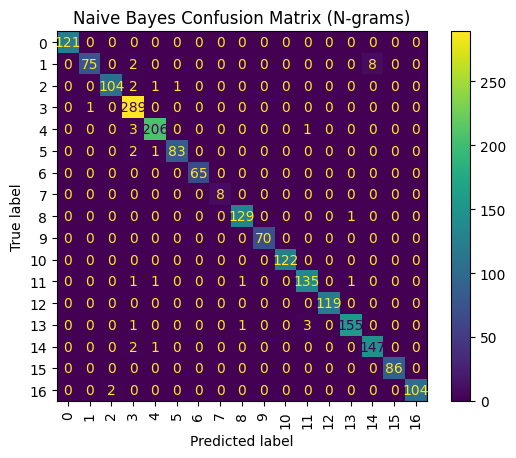


Testing with TF-IDF representation...

Naive Bayes Accuracy (TF-IDF): 0.9060827250608272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      0.45      0.62        85
           2       1.00      0.59      0.74       108
           3       0.61      1.00      0.76       290
           4       0.99      0.97      0.98       210
           5       1.00      0.44      0.61        86
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96       130
           9       1.00      1.00      1.00        70
          10       1.00      1.00      1.00       122
          11       0.99      0.95      0.97       139
          12       1.00      1.00      1.00       119
          13       0.99      0.95      0.97       160
          14       0.96      0.91      0.93       150
          15       1.00      1.00      1.00  

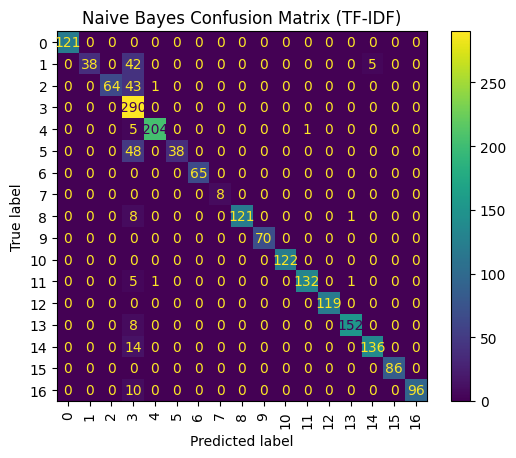

In [ ]:
"""
# -------------------
# Naive Bayes
# -------------------
"""

for representation_name, X in data_representations.items():
   print(f"\nTesting with {representation_name} representation...\n")

   # Train-Test Split
   X_train, X_test, y_train, y_test = train_test_split(X, languages_array, test_size=0.2, random_state=42)

   # Naive Bayes
   nb_model = MultinomialNB()
   nb_model.fit(X_train, y_train)
   y_pred_nb = nb_model.predict(X_test)
   nb_accuracy = accuracy_score(y_test, y_pred_nb)
   print(f"Naive Bayes Accuracy ({representation_name}): {nb_accuracy}")
   print(classification_report(y_test, y_pred_nb))


   cm_nb = confusion_matrix(y_test, y_pred_nb)
   ConfusionMatrixDisplay(cm_nb, display_labels=np.arange(len(label_encoder.classes_))).plot(cmap='viridis', xticks_rotation='vertical')
   plt.title(f"Naive Bayes Confusion Matrix ({representation_name})")
   plt.show()

# -------------------
# Model Performance Summary
# -------------------
# Test Accuracy: 0.98199 (N-grams)
# Notes:
# - Overall accuracy: 98%, showcasing excellent performance
# - Strengths:Performs well for virtually all languages, very little dropoff (label 14 is the worst but may be due to not enough data)

# Test Accuracy: 0.9060 (TF-IDF)
# Notes:
# - Overall accuracy: 91%
# - Strengths:Performs well for virtually all languages, except for a major dropoff for Label 3 (61%)
# - Bad recall and f1 for label 2, 3

SVM Accuracy (TF-IDF): 0.981021897810219
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       121
           1       0.94      0.98      0.96        85
           2       0.98      0.95      0.97       108
           3       0.98      1.00      0.99       290
           4       0.99      0.97      0.98       210
           5       0.98      1.00      0.99        86
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00         8
           8       0.98      0.95      0.96       130
           9       1.00      1.00      1.00        70
          10       1.00      1.00      1.00       122
          11       0.96      0.96      0.96       139
          12       1.00      1.00      1.00       119
          13       0.95      0.97      0.96       160
          14       0.99      0.97      0.98       150
          15       1.00      1.00      1.00        86
          16       0.98      0.98      0

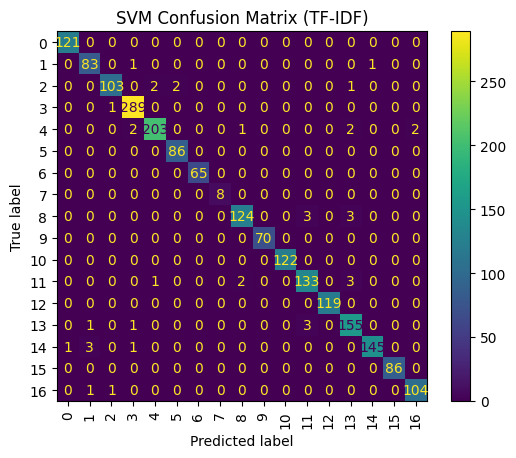

In [ ]:
"""
# -------------------
# SVM
# -------------------
"""

# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy ({representation_name}): {svm_accuracy}")
print(classification_report(y_test, y_pred_svm))


cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=np.arange(len(label_encoder.classes_))).plot(cmap='viridis', xticks_rotation='vertical')
plt.title(f"SVM Confusion Matrix ({representation_name})")
plt.show()
results[representation_name] = {
       'Naive Bayes': nb_accuracy,
       'SVM': svm_accuracy
   }
# -------------------
# Model Performance Summary
# -------------------
# Test Accuracy: 0.98102
# Notes:
# - Overall accuracy: 98%, showcasing excellent performance
# - Strengths:Performs well for virtually all languages, very little dropoff (label 13 is the worst but may be due to not enough data)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 194s 887ms/step - accuracy: 0.2401 - loss: 2.3161 - val_accuracy: 0.8157 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 770ms/step - accuracy: 0.8516 - loss: 0.4893 - val_accuracy: 0.9124 - val_loss: 0.2930 - learning_rate: 0.0010
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 199s 754ms/step - accuracy: 0.9517 - loss: 0.1744 - val_accuracy: 0.9227 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 768ms/step - accuracy: 0.9731 - loss: 0.1005 - val_accuracy: 0.9453 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 202s 770ms/step - accuracy: 0.9831 - loss: 0.0636 - val_accuracy: 0.9392 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 204s 777ms/step - accuracy: 0.9803 - loss: 0.0680 - val_accuracy: 0.9453 - val_loss: 0.2091 - learning_rate: 0.0010
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 201s 775ms/step - accura

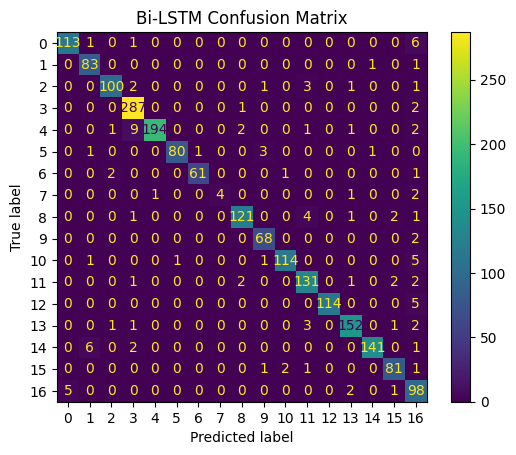

Bi-LSTM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       121
           1       0.90      0.98      0.94        85
           2       0.96      0.93      0.94       108
           3       0.94      0.99      0.97       290
           4       0.99      0.92      0.96       210
           5       0.99      0.93      0.96        86
           6       0.98      0.94      0.96        65
           7       1.00      0.50      0.67         8
           8       0.96      0.93      0.95       130
           9       0.92      0.97      0.94        70
          10       0.97      0.93      0.95       122
          11       0.92      0.94      0.93       139
          12       1.00      0.96      0.98       119
          13       0.96      0.95      0.95       160
          14       0.99      0.94      0.96       150
          15       0.93      0.94      0.94        86
          16       0.74      0.92      0.82       1

In [ ]:
"""
# -------------------
# Bi-LSTM
# -------------------
"""

label_encoder = LabelEncoder()
languages_encoded = label_encoder.fit_transform(languages)
languages_array = np.array(languages_encoded)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, languages_array, test_size=0.2, random_state=42)


# Learning Rate Scheduler
def lr_schedule(epoch, lr):
   if epoch < 10:
       return lr
   else:
       return lr * 0.1


lr_scheduler = LearningRateScheduler(lr_schedule)


# Early Stopping Setting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Bi-LSTM 모델 설계
bi_lstm_model = Sequential([
   Embedding(input_dim=20000, output_dim=128, input_length=100),
   Bidirectional(LSTM(128, return_sequences=True)),  # 첫 번째 Bi-LSTM 레이어
   Dropout(0.3),
   Bidirectional(LSTM(128, return_sequences=False)),  # 두 번째 Bi-LSTM 레이어
   Dropout(0.3),
   Dense(128, activation='relu'),
   Dropout(0.3),
   Dense(len(set(y_train)), activation='softmax')
])


# Choose Optimizer
optimizer = Adam(learning_rate=1e-3)


# 모델 컴파일
bi_lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit Model
history = bi_lstm_model.fit(
   X_train, y_train,
   validation_split=0.2,
   epochs=10,
   batch_size=32,
   callbacks=[early_stopping, lr_scheduler],
   verbose=1
)


# Model Evaluation
loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Bi-LSTM Test Accuracy: {bi_lstm_accuracy}")


results['Bi-LSTM'] = {'Accuracy': bi_lstm_accuracy}


# Bi-LSTM Prediction
y_pred_bilstm = np.argmax(bi_lstm_model.predict(X_test), axis=1)


# Confusion Matrix
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
ConfusionMatrixDisplay(cm_bilstm, display_labels=np.arange(len(label_encoder.classes_))).plot(cmap='viridis')
plt.title("Bi-LSTM Confusion Matrix")
plt.show()


# Bi-LSTM Classification Report
print("Bi-LSTM Classification Report")
print(classification_report(y_test, y_pred_bilstm, target_names=[str(i) for i in range(len(label_encoder.classes_))]))

# -------------------
# Model Performance Summary
# -------------------
# Test Accuracy: 0.95
# Notes:
# - Strengths: Decent performance
# - Weakneasses: Label 16 has 74% accuracy, label 1, 9 and 11 have about 90% precision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Training Data Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Testing Data Labels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/8216 [00:00<?, ? examples/s]

Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-e9ef9cf34aaa>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.116900,0.063242,0.989294
2,0.053000,0.062483,0.989294


Test Accuracy: 0.9892944097518921


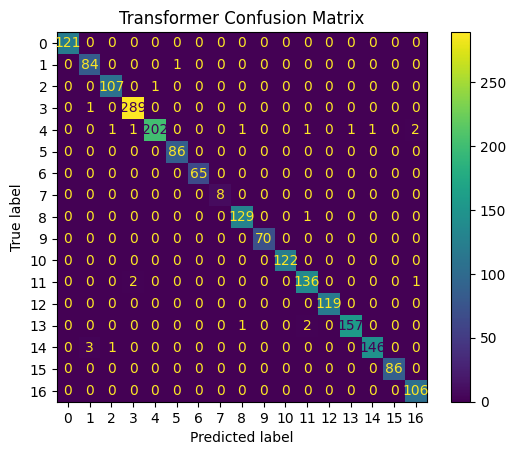

Transformer Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.95      0.99      0.97        85
           2       0.98      0.99      0.99       108
           3       0.99      1.00      0.99       290
           4       1.00      0.96      0.98       210
           5       0.99      1.00      0.99        86
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00         8
           8       0.98      0.99      0.99       130
           9       1.00      1.00      1.00        70
          10       1.00      1.00      1.00       122
          11       0.97      0.98      0.97       139
          12       1.00      1.00      1.00       119
          13       0.99      0.98      0.99       160
          14       0.99      0.97      0.98       150
          15       1.00      1.00      1.00        86
          16       0.97      1.00      0.99    

In [ ]:
"""
# -------------------
# Transformer 모델
# -------------------
"""

! pip install datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset

#Label Conversion for Transformer data prep
label_encoder = LabelEncoder()
languages_encoded = label_encoder.fit_transform(languages)
languages_array = np.array(languages_encoded)

label_encoder = LabelEncoder()
label_encoder.fit(languages_array)
y_encoded = label_encoder.transform(languages_array)


# Train-Test Split
train_texts, test_texts, y_train, y_test = train_test_split(word_list, y_encoded, test_size=0.2, random_state=42)


print("Training Data Labels:", set(y_train))
print("Testing Data Labels", set(y_test))


tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')


train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=100)


train_dataset = Dataset.from_dict({
   'input_ids': train_encodings['input_ids'],
   'attention_mask': train_encodings['attention_mask'],
   'labels': y_train
})
test_dataset = Dataset.from_dict({
   'input_ids': test_encodings['input_ids'],
   'attention_mask': test_encodings['attention_mask'],
   'labels': y_test
})


# Encode Dataset to PyTorch Tensor
def encode_dataset(dataset):
   return dataset.map(lambda e: {key: torch.tensor(val) for key, val in e.items()})


train_dataset = encode_dataset(train_dataset)
test_dataset = encode_dataset(test_dataset)


# Transformer Model
model = AutoModelForSequenceClassification.from_pretrained(
   'bert-base-multilingual-cased',
   num_labels=len(label_encoder.classes_)
)


# Training Arguments
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=2,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   evaluation_strategy="epoch",
   logging_dir='./logs',
   learning_rate=3e-5,
   logging_steps=10,
   save_strategy="epoch",
   report_to="none" 
)


trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=test_dataset,
   tokenizer=tokenizer,
   compute_metrics=lambda eval_pred: {
       'accuracy': (torch.tensor(eval_pred.predictions).argmax(dim=1) == torch.tensor(eval_pred.label_ids)).float().mean().item()
   }
)


# Model Train
trainer.train()


# Model Evaluation
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']}")


# Transformer Prediction
transformer_predictions = trainer.predict(test_dataset)
y_pred_transformer = np.argmax(transformer_predictions.predictions, axis=1)


# Confusion Matrix
cm_transformer = confusion_matrix(y_test, y_pred_transformer)
ConfusionMatrixDisplay(cm_transformer, display_labels=np.arange(len(label_encoder.classes_))).plot(cmap='viridis')
plt.title("Transformer Confusion Matrix")
plt.show()


# Transformer Classification Report
print("Transformer Classification Report")
print(classification_report(y_test, y_pred_transformer, target_names=[str(i) for i in range(len(label_encoder.classes_))]))

# -------------------
# Model Performance Summary
# -------------------
# Test Accuracy: 0.9893
# Notes:
# - Overall accuracy: 99%, showcasing excellent performance
# - Strengths: No drop-offs really, label 1 has the lowest precision results with a precision of 95%

In [5]:
#Encoding Key (which number is associated to which language for all models)
for i in range(len(label_encoder.classes_)):
  encoding = i
  label = label_encoder.classes_[i]
  print(f"{encoding}:{label}")

0:Arabic
1:Danish
2:Dutch
3:English
4:French
5:German
6:Greek
7:Hindi
8:Italian
9:Kannada
10:Malayalam
11:Portugeese
12:Russian
13:Spanish
14:Sweedish
15:Tamil
16:Turkish
